In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
from collections import Counter
from pandas import concat
from scipy.stats import spearmanr
import seaborn as sns
from pylab import rcParams

rcParams['figure.figsize'] = 18,12

# **Importing and Pre-processing Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All

In [ ]:
df_UN= pd.read_csv('drive/My Drive/DL Project/Upper Niho/Upper_Niho_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_M= pd.read_csv('drive/My Drive/DL Project/Mangatangi/Mangatangi_All.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_W= pd.read_csv('drive/My Drive/DL Project/Waitakere/Waitakere_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

No Comp/Abs

In [ ]:
df_UN_CA= pd.read_csv('drive/My Drive/DL Project/Upper Niho/Upper_Niho_NoCompAbs.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_M_CA= pd.read_csv('drive/My Drive/DL Project/Mangatangi/Mangatangi_NoCompAbs.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_W_CA= pd.read_csv('drive/My Drive/DL Project/Waitakere/Waitakere_NoCompAbs.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

Level/Spill

In [ ]:
df_UN_LS= pd.read_csv('drive/My Drive/DL Project/Upper Niho/Upper_Niho_FullLevels.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_M_LS= pd.read_csv('drive/My Drive/DL Project/Mangatangi/Mangatangi_LevelSpill.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_W_LS= pd.read_csv('drive/My Drive/DL Project/Waitakere/Waitakere_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

In [ ]:
df1 = df_W



---


**Missing Values**

Missing values for Level and Spill are filled by linear interpolation. 

In [ ]:
df1.isnull().sum(axis=0)

Level                 0
Spill                 0
Rainfall (WSL)        0
Soil Moisture         0
Vapour Pressure       0
Max Temp              0
Rainfall (NiWa)       0
Penman Evaporation    0
Solar Radiation       0
dtype: int64

In [ ]:
df1['Rainfall (WSL)'].fillna(df1['Rainfall (NiWa)'], inplace=True)

In [ ]:
df1['Level'] = df1['Level'].interpolate(method='slinear').interpolate(method='linear')
df1['Spill'] = df1['Spill'].interpolate(method='slinear').interpolate(method='linear')

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Level,9877.0,50.246028,3.784058,33.991,48.224,50.819,53.449,55.051
Spill,9877.0,0.138422,0.896565,0.000,0.000,0.000,0.000,30.062
Rainfall (WSL),9205.0,4.876460,11.176610,0.000,0.000,0.500,4.500,169.540
Rainfall (NIWA),9943.0,4.605471,10.544921,0.000,0.000,0.000,4.500,158.800
Soil Moisture,9943.0,-36.310460,43.399244,-146.300,-69.450,-20.700,-1.300,110.200
Max Temp,9943.0,18.765523,3.989994,7.300,15.500,18.500,22.000,29.600
Penman Evaporation,9943.0,2.588615,1.543391,0.000,1.200,2.300,3.800,7.100
Vapour Pressure,9943.0,13.954621,3.495905,5.500,11.400,13.600,16.400,26.200
Solar Radiation,9943.0,14.197003,7.251340,0.500,8.300,13.000,19.650,38.200


## Accounting for Seasonality

In [ ]:
df1['Day'] = df1.index.dayofyear

In [ ]:
_day = df1['Day']

In [ ]:
df1 = df1.drop(['Day'], axis=1)

In [ ]:
df1.shape

(11117, 8)

In [ ]:
month = 365.2425/12
year = (365.2425)

df1['Year sin'] = np.sin(_day * (2 * np.pi / year))
df1['Year cos'] = np.cos(_day * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Year signal')

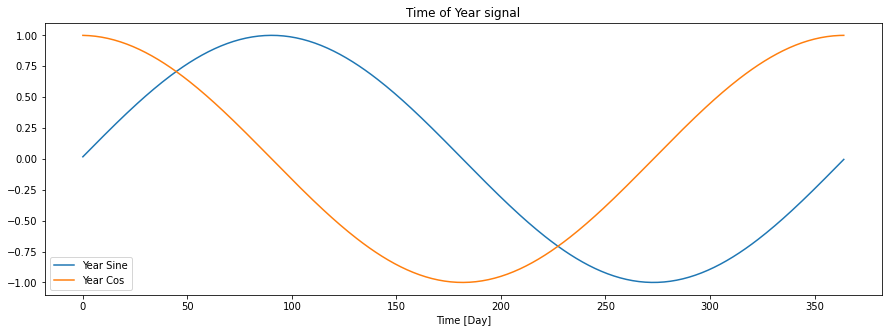

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(np.array(df1['Year sin'])[:365], label='Year Sine')
plt.plot(np.array(df1['Year cos'])[:365],label='Year Cos')
plt.legend()
plt.xlabel('Time [Day]')
plt.title('Time of Year signal')

## Adding Year/Month Columns

In [ ]:
df1 = df1.reset_index()

In [ ]:
df1['year'] = pd.DatetimeIndex(df1['Date']).year
df1['month'] = pd.DatetimeIndex(df1['Date']).month

In [ ]:
df1 = df1.set_index('Date')

## Adding Shifted Values

In [ ]:
df1['Rainfall-1'] = df1['Rainfall (WSL)'].shift(-1)

In [ ]:
df1['Rainfall-2'] = df1['Rainfall (NiWa)'].shift(-1)

In [ ]:
df1['Rainfall-3'] = df1['Rainfall (WSL)'].shift(-2)

In [ ]:
df1['Rainfall-7'] = df1['Rainfall (NiWa)'].shift(-2)

In [ ]:
#df1['Rainfall-30'] = df1['Rainfall (WSL)'].shift(-30)

In [ ]:
df1 = df1[:-7]

# **Augmented Dickey Fuller Test - Stationarity**

To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

First, let's plot the data along with a 12-month rolling mean and standard deviation:

In [ ]:
from statsmodels.tsa.stattools import adfuller 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
adfuller(df1['Observed Penman Evaporation'])

(-4.196701892637029,
 0.0006674217548343121,
 31,
 4079,
 {'1%': -3.4319541725909395,
  '10%': -2.5671473200905073,
  '5%': -2.8622488355984346},
 9978.14975351005)

In [ ]:
df1test = adfuller(df1['Solar Radiation'])
df1out = pd.Series(df1test[0:4], index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations'])

In [ ]:
for key, val in df1test[4].items():
  df1out[f'critical value ({key})'] = val

In [ ]:
df1out

ADF Test Statistic        -3.815351
p-value                    0.002754
# Lags Used               31.000000
# Observations          4079.000000
critical value (1%)       -3.431954
critical value (5%)       -2.862249
critical value (10%)      -2.567147
dtype: float64

In [ ]:
df2.head()

,Level,Spill
Date,,
1978-01-02,31.867,0.0
1978-01-03,31.665,0.0
1978-01-04,31.478,0.0
1978-01-05,31.301,0.0
1978-01-06,31.058,0.0


In this case our p-value is very low at 1.317092e-11, and we reject the null hypothesis. This dataset appears to have no unit root, and is stationary.

## Dickey Fuller as a Function

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
adf_test(df1)

Augmented Dickey-Fuller Test: 


ValueError: ignored

In [ ]:
adf_test(df1['Level'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.404921e+00
p-value                 7.387821e-11
# lags used             3.300000e+01
# observations          1.568600e+04
critical value (1%)    -3.430767e+00
critical value (5%)    -2.861724e+00
critical value (10%)   -2.566868e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# **Granger Causality Test**

The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
grangercausalitytests(df1[['Level (last)', 'Solar Radiation']], maxlag=7)

# Modified Mann-Kendall

In [ ]:
!pip install pymannkendall

In [ ]:
import pymannkendall as mk

In [ ]:
result = mk.hamed_rao_modification_test(df1['Level'], lag=3)

In [ ]:
result = mk.correlated_seasonal_test(df1['Level'])

In [ ]:
print(result)

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.37156826989391023, z=0.8935396102023375, Tau=0.01536179721878338, s=813206.0, var_s=828271011412.7186, slope=5.5733828745146515e-06, intercept=32.020327731802055)


In [ ]:
for i in range(len(df1.columns)):
  result = mk.correlated_seasonal_test(df1[df1.columns[i]])
  print(f'{df1.columns[i]}. Result: {result[0]}')


Level. Result: no trend
Spill. Result: no trend
Rainfall (WSL). Result: increasing
Soil Moisture. Result: no trend
Vapour Pressure. Result: no trend
Max Temp. Result: no trend
Rainfall (NiWa). Result: no trend
Penman Evaporation. Result: increasing
Solar Radiation. Result: increasing


# **Seasonality**

Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.
<div class="alert alert-info"><h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html'>tsaplots.month_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;&nbsp;Seasonal plot of monthly data<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.quarter_plot.html'>tsaplots.quarter_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Seasonal plot of quarterly data</tt>
</div>

In [ ]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

In [ ]:
df1q = df1['Level'].resample(rule='Q').mean()
quarter_plot(df1q);

# **Line Plots**

In [ ]:
plt.figure(figsize=(12, 9))
for i in range(len(df1.columns)):
	# create subplot
	plt.subplot(len(df1.columns), 1, i+1)
	# get variable name
	name = df1_shift.columns[i]
	# plot data
	plt.plot(df1[name])
	# set title
	plt.title(name, y=0)
	# turn off ticks to remove clutter
	plt.yticks([])
	plt.xticks([])
plt.show()

## Summary

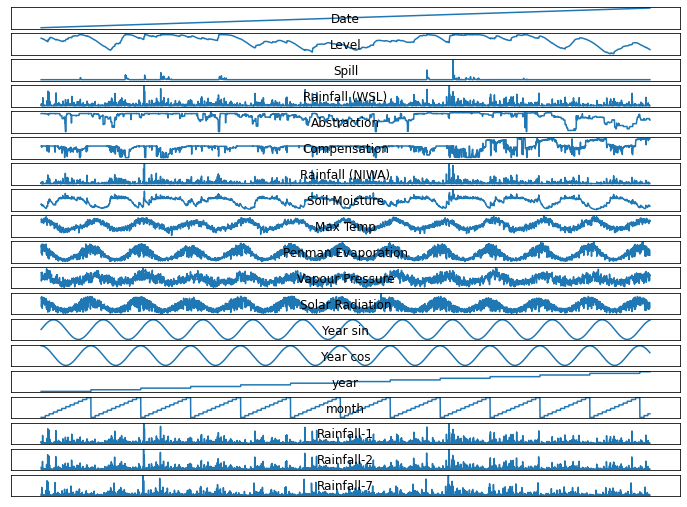

In [ ]:
plt.figure(figsize=(12, 9))
for i in range(len(df1.columns)):
	# create subplot
	plt.subplot(len(df1.columns), 1, i+1)
	# get variable name
	name = df1.columns[i]
	# plot data
	plt.plot(df1[name])
	# set title
	plt.title(name, y=0)
	# turn off ticks to remove clutter
	plt.yticks([])
	plt.xticks([])
plt.show()

## Yearly

In [ ]:
years = ['2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019', '2020']
plt.figure(figsize=(12, 9))
for i in range(len(years)):
	# prepare subplot
	ax = plt.subplot(len(years), 1, i+1)
	# determine the year to plot
	year = years[i]
	# get all observations for the year
	result = df1[str(year)]
	# plot the active power for the year
	plt.plot(result['Level'])
	# add a title to the subplot
	plt.title(str(year), y=0, loc='left')
	# turn off ticks to remove clutter
	plt.yticks([])
	plt.xticks([])
plt.show()

# **Autocorrelation & Partial Autocorrelation**

**Autocorrelation:**

The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
import warnings
warnings.filterwarnings ('ignore')

Text(0, 0.5, 'Autocorrelation')

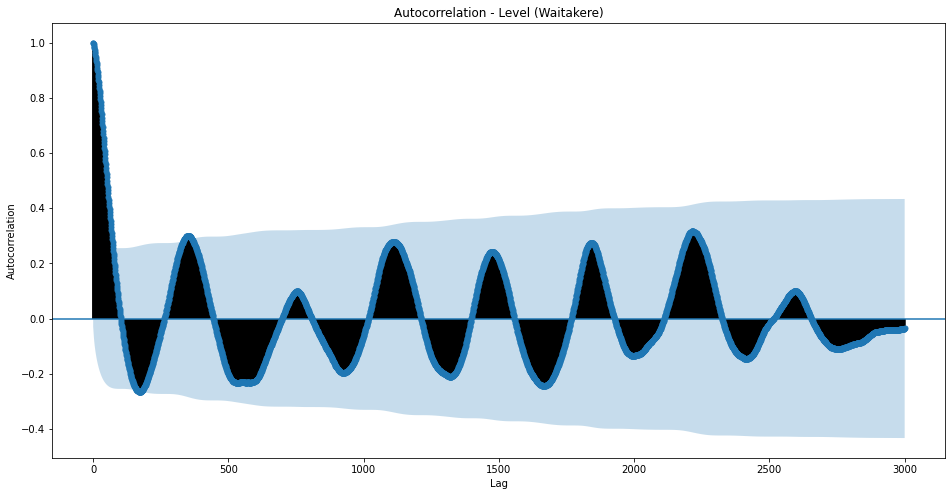

In [ ]:
plt.rc("figure", figsize=(16,8))
#plt.figure(figsize=(16,12))
plot_acf(df1['Level'],title='Autocorrelation - Level (Waitakere)',lags=3000);
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

The light blue shaded interval shows the 95% confidence intervals. The values outside of this interval are likely to be correlated. 


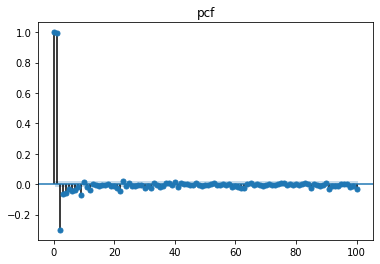

In [ ]:
plot_pacf(df1['Level'],title='pcf',lags=100);

# **Time Series Data Distributions**




## Normality Test

In [ ]:
from scipy.stats import shapiro

In [ ]:
for i in range(len(df1.columns)):
  name = df1.columns[i]
  stat, p = shapiro(df1[df1.columns[i]])
  print(f'{name} - Statistics =%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
	  print('Sample looks Gaussian (fail to reject H0)')
  else:
	  print('Sample does not look Gaussian (reject H0)')
  # result = mk.correlated_seasonal_test(df1[df1.columns[i]])
  # print(f'{df1.columns[i]}. Result: {result[0]}')


Level - Statistics =0.908, p=0.000
Sample does not look Gaussian (reject H0)
Spill - Statistics =0.144, p=0.000
Sample does not look Gaussian (reject H0)
Rainfall (WSL) - Statistics =0.480, p=0.000
Sample does not look Gaussian (reject H0)
Rainfall (NIWA) - Statistics =0.489, p=0.000
Sample does not look Gaussian (reject H0)
Soil Moisture - Statistics =0.907, p=0.000
Sample does not look Gaussian (reject H0)
Max Temp - Statistics =0.979, p=0.000
Sample does not look Gaussian (reject H0)
Penman Evaporation - Statistics =0.944, p=0.000
Sample does not look Gaussian (reject H0)
Vapour Pressure - Statistics =0.989, p=0.000
Sample does not look Gaussian (reject H0)
Solar Radiation - Statistics =0.966, p=0.000
Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Histograms 

### All Variables

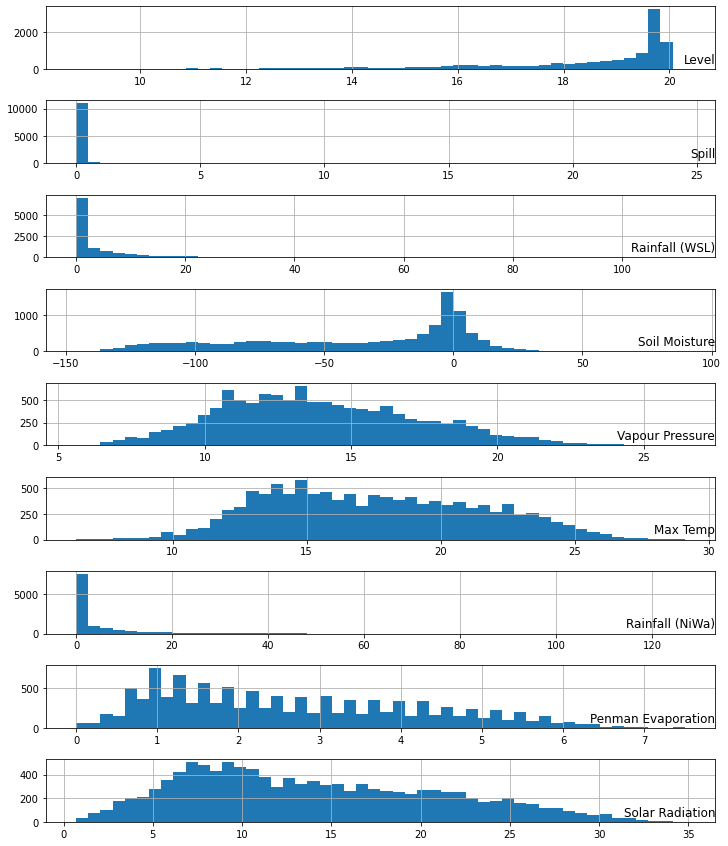

In [ ]:
plt.figure(figsize=(12, 15))
for i in range(len(df1.columns)):
	# create subplot
	plt.subplot(len(df1.columns), 1, i+1)
	# get variable name
	name = df1.columns[i]
	# create histogram
	df1[name].hist(bins=50)
	# set title
	plt.title(name, y=0, loc='right')
	# turn off ticks to remove clutter
	plt.subplots_adjust(hspace=0.5)
	#plt.ylabel("Level (m)")
  #plt.title(f'{site} - +{shift_steps} Day Performance on Test Set ({model_type})')  
plt.show()

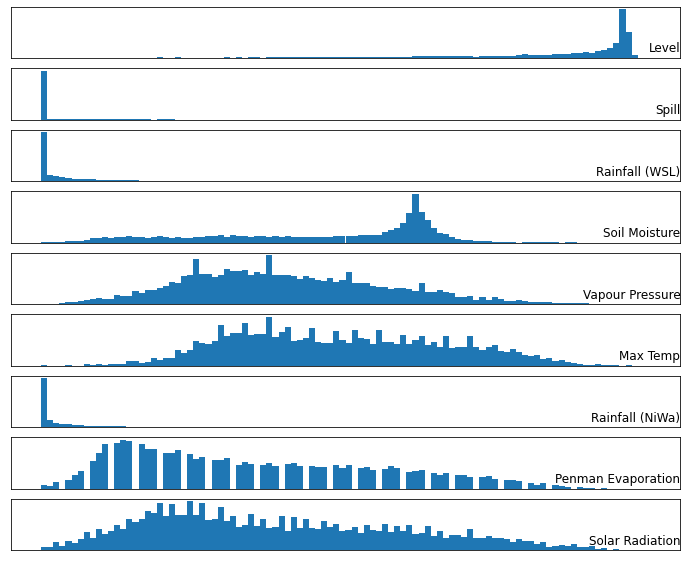

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(len(df1.columns)):
	# create subplot
	plt.subplot(len(df1.columns), 1, i+1)
	# get variable name
	name = df1.columns[i]
	# create histogram
	df1[name].hist(bins=100)
	# set title
	plt.title(name, y=0, loc='right')
	# turn off ticks to remove clutter
	plt.yticks([])
	plt.xticks([])
plt.show()

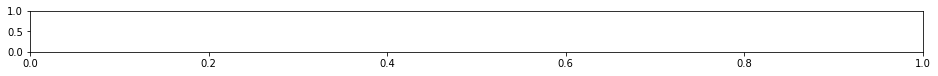

In [ ]:
plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.subplot(len(df1.columns), 1, i+1)
plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.subplot(len(df1.columns), 1, i+1)
plt.show()

### Yearly




In [ ]:
years = ['2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019', '2020']
plt.figure(figsize=(16,12))
for i in range(len(years)):
	# prepare subplot
	ax = plt.subplot(len(years), 1, i+1)
	# determine the year to plot
	year = years[i]
	# get all observations for the year
	result = df1[str(year)]
	# plot the active power for the year
	result['Soil Moisture'].hist(bins=100)
	# zoom in on the distribution
	##ax.set_xlim(15, 35)
	# add a title to the subplot
	plt.title(str(year), y=0, loc='right')
	# turn off ticks to remove clutter
	plt.yticks([])
	plt.xticks([])
plt.show()

*For Level, multimodal distribution more prominent in 2019.*


---




# **Spearman and Pearsons Correlation**


Correlations summarize the statistical relationship between two variables. The Pearson's Correlation coefficient is a number between 1 and -1 describing a positive or negative correlation. The strength of the correlation is reflected by the value being closer to 1 or -1, where a coefficient of 1 or -1 denotes a strong linear positive or negative correlation. A coefficient close to or at 0 describes weak or no correlation. 

(https://pubs.usgs.gov/of/2004/1412/correlation.html) A correlation analysis can be used to assess the strength of association between two continuous variables, but cannot be used to prove a casual relation between the two variables (Helsel and Hirsch, 1992). Three main methods of determining correlation are Pearson's r, Spearman's p, and Kendall's T. Pearson's r is used to evaluate linear correlation, Spearman's p is used to evaluate nonlinear correlation, and Kendall's tau can be used to evaluate either linear or nonlinear correlation. Spearman's p and Kendall's T are both rank-based methods.

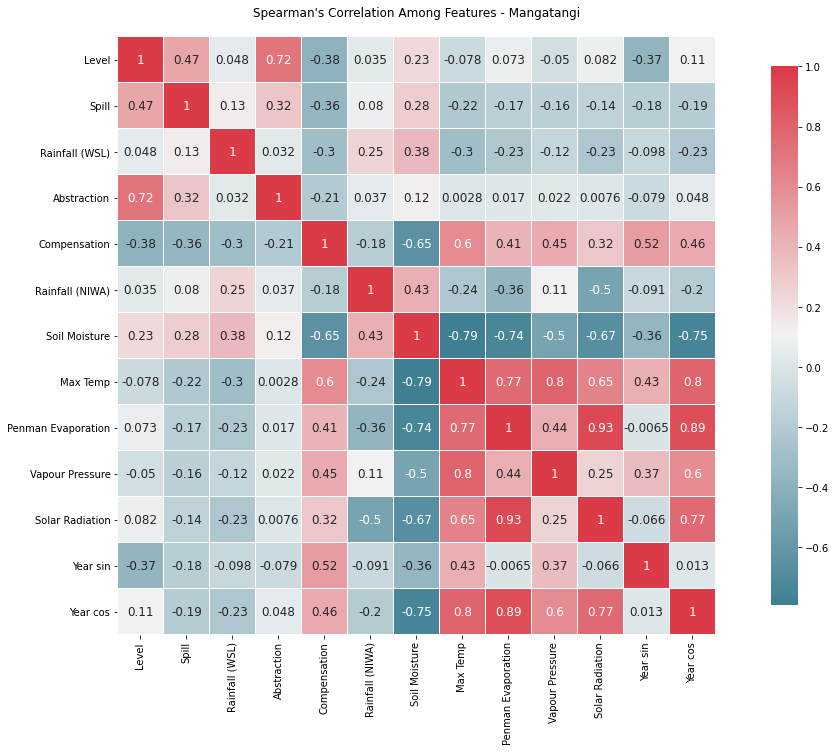

In [ ]:
fig, ax = plt.subplots(figsize=(20, 11))
sns.heatmap(
        df1.corr('spearman'), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.title("Spearman's Correlation Among Features - Mangatangi", pad=20)
plt.show()

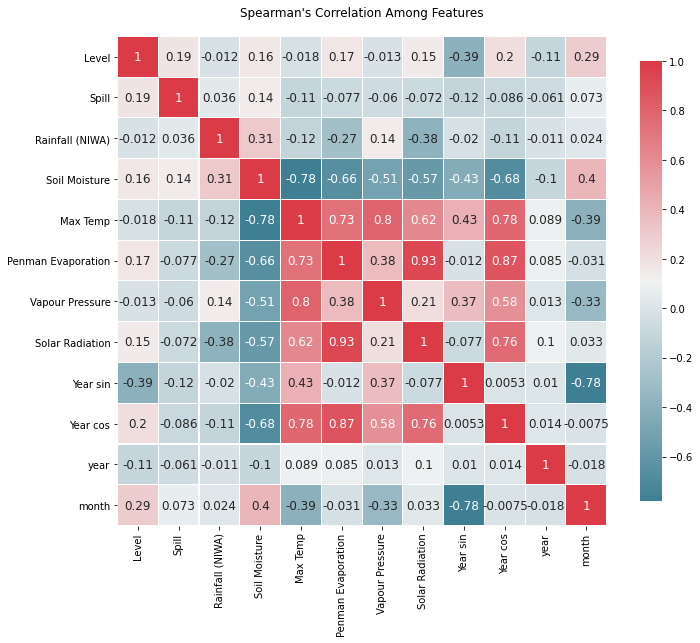

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
        df1_shift.corr('pearson'), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.title("Spearman's Correlation Among Features", pad=20)
plt.show()

In [ ]:
var1 = df1['Level (last)'].squeeze()
var2 = df1['Vapour Pressure (hPa)'].squeeze()

In [ ]:
coef, p = spearmanr(var1, var2, axis=1)

# **Box Plots**

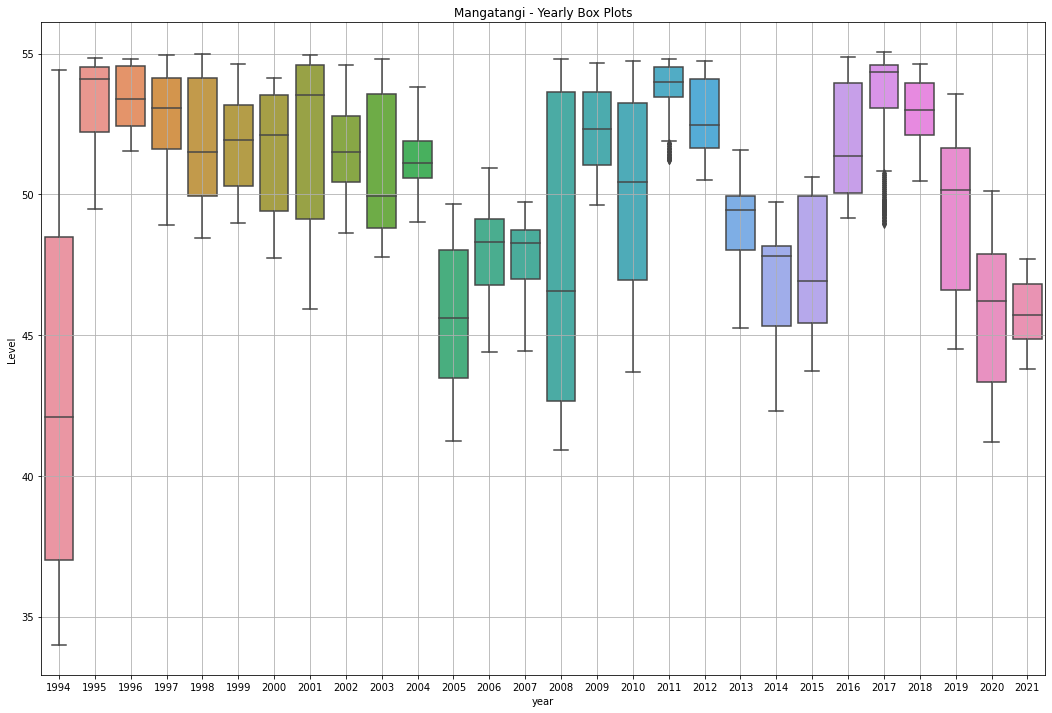

In [ ]:
sns.boxplot(x =df1['year'] ,y = df1['Level'])
plt.title('Mangatangi - Yearly Box Plots');
plt.grid();

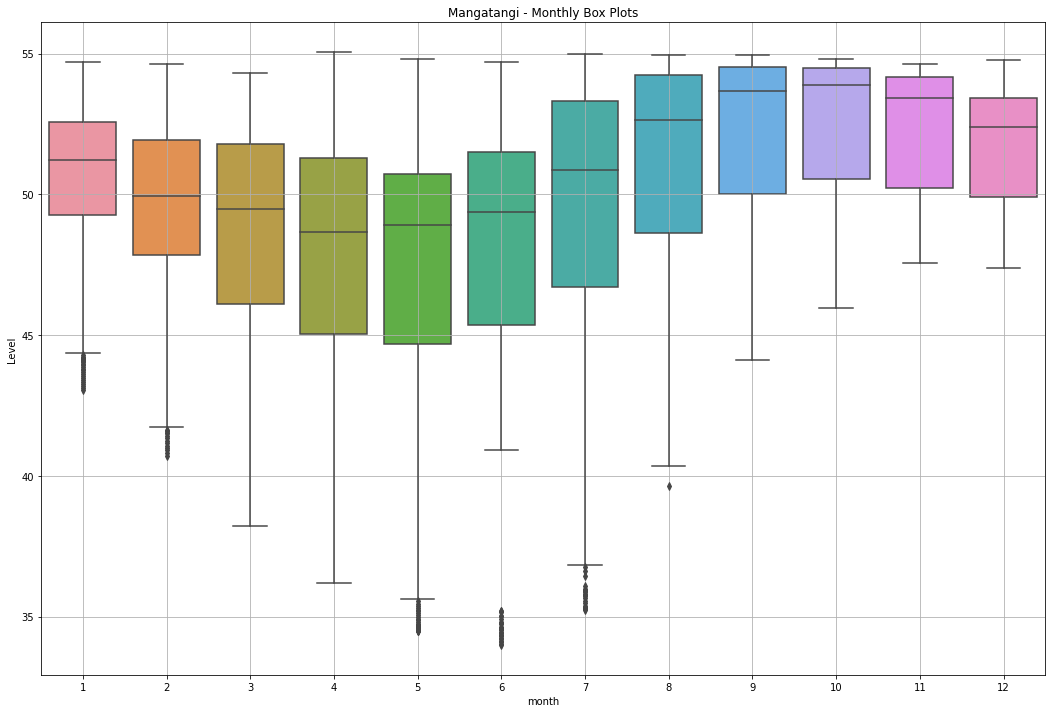

In [ ]:
sns.boxplot(x =df1['month'] ,y = df1['Level'])
plt.title('Mangatangi - Monthly Box Plots');
plt.grid();